# Working with messages

## Lesson goals
- Understand the messages API format
- Work wit and understand model response objects
- Build a simple multi-turn chatbot

## Basic setup
We'll start by importing the packages we need and initializing a client object.
See the previous tutorial for details on how to get an API key and properly store it.  

In [6]:
from dotenv import load_dotenv
from anthropic import Anthropic

#load environment variable
load_dotenv()

#automatically looks for an "ANTHROPIC_API_KEY" environment variable
client = Anthropic()

## Messages format

As we saw in the previous lesson, we can use `client.messages.create()` to send a message to Claude and get a response:

In [5]:
response = client.messages.create(
    model="claude-3-haiku-20240307",
    max_tokens=1000,
    messages=[
        {"role": "user", "content": "What flavors are used in Dr. Pepper?"}
    ]
)

print(response)

Message(id='msg_013wVsHLHRjuDM2WgvVJ8RNm', content=[ContentBlock(text='The exact flavor formula for Dr Pepper is a closely guarded trade secret, but here are some of the main flavors that are believed to be used:\n\n- Cherry - This is one of the most prominent flavors in Dr Pepper. The cherry flavor comes from the use of a type of cherry extract.\n\n- Prune - Dr Pepper contains a prune-like flavor which contributes to its unique profile.\n\n- Vanilla - Vanilla is another key component that helps round out the flavor.\n\n- Spices - Various spices like cinnamon, prune, and other aromatics are believed to be part of the blend.\n\n- Citrus - Flavors like orange, lemon, and prune add some citrus notes.\n\nThe exact combination of these and other secret ingredients is what gives Dr Pepper its signature taste that differentiates it from other cola or soda flavors. The complex blend of sweet, spicy, and tart notes is part of what makes Dr Pepper a unique and iconic soft drink flavor.', type='t

Let's take a closer look at this bit: 
```py
messages=[
        {"role": "user", "content": "What flavors are used in Dr. Pepper?"}
    ]
```

The messages parameter is a crucial part of interacting with the Claude API. It allows you to provide the conversation history and context for Claude to generate a relevant response. 

The messages parameter expects a list of message dictionaries, where each dictionary represents a single message in the conversation.
Each message dictionary should have the following keys:

* `role`: A string indicating the role of the message sender. It can be either "user" (for messages sent by the user) or "assistant" (for messages sent by Claude).
* `content`: A string or list of content dictionaries representing the actual content of the message. If a string is provided, it will be treated as a single text content block. If a list of content dictionaries is provided, each dictionary should have a "type" (e.g., "text" or "image") and the corresponding content.  For now, we'll leave `content` as a single string.

Here's an example of a messages list with a single user message:

```py
messages = [
    {"role": "user", "content": "Hello Claude! How are you today?"}
]
```

And here's an example with multiple messages representing a conversation:

```py
messages = [
    {"role": "user", "content": "Hello Claude! How are you today?"},
    {"role": "assistant", "content": "Hello! I'm doing well, thank you. How can I assist you today?"},
    {"role": "user", "content": "Can you tell me a fun fact about ferrets?"},
    {"role": "assistant", "content": "Sure! Did you know that excited ferrets make a clucking vocalization known as 'dooking'?"},
]
```

Remember that messages always alternate between user and assistant messages.

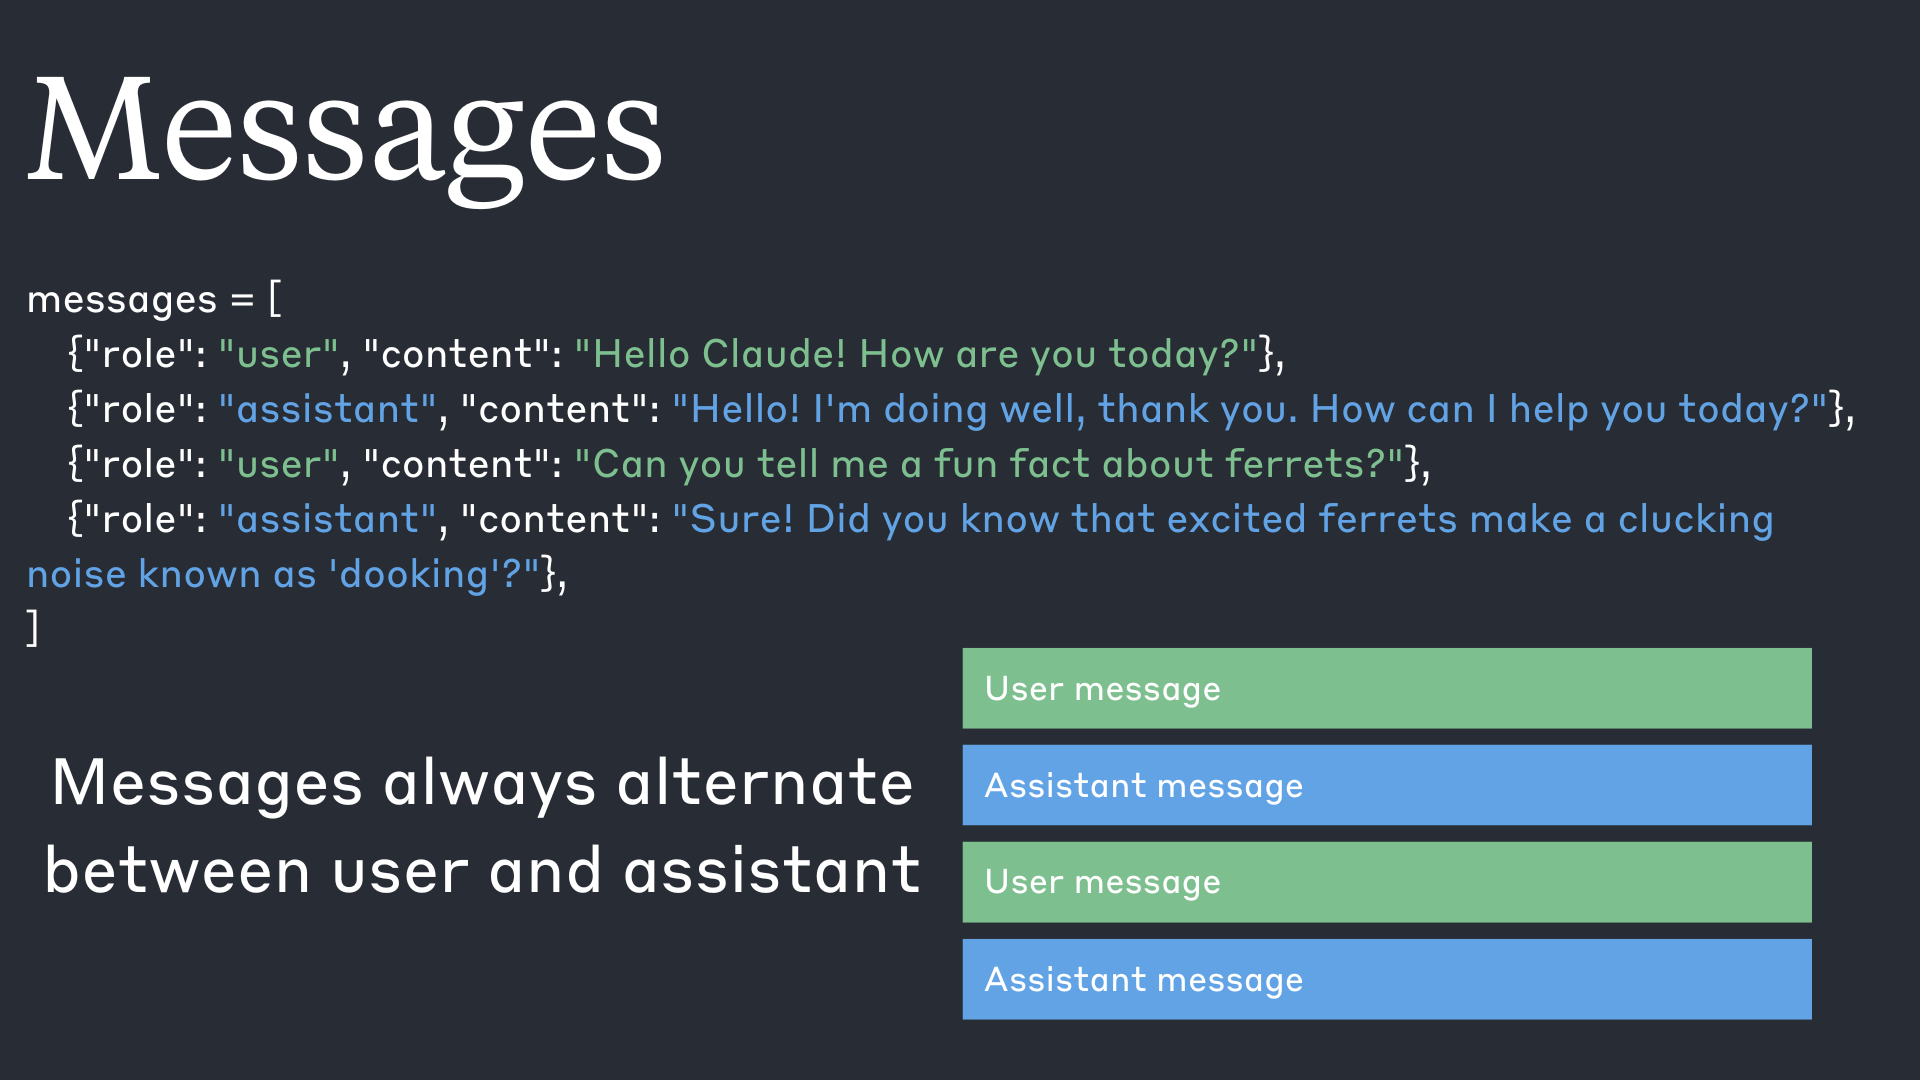

The messages format allows us to structure our API calls to Claude in the form of a conversation, allowing for **context preservation**: The messages format allows for maintaining an entire conversation history, including both user and assistant messages. This ensures that Claude has access to the full context of the conversation when generating responses, leading to more coherent and relevant outputs.  

**Note: many use-cases don't require a conversation history, and there's nothing wrong with providing a list of messages that only contains a single message!** 

***

## Quiz

What are the two required keys in each message? 

* **a)** "sender" and "text"
* **b)** "role" and "content"
* **c)** "user" and "assistant"
* **d)** "input" and "output"

<details>
  <summary>View quiz answer</summary>
  
  **The correct answer is b.  Every message should have a "role" and "content"**

</details>




***

## Inspecting the message response
Next, let's take a look at the shape of the response we get back from Claude. 

Let's ask Claude to do something simple:

In [7]:
response = client.messages.create(
    model="claude-3-haiku-20240307",
    max_tokens=1000,
    messages=[
        {"role": "user", "content": "Translate hello to French. Respond with a single word"}
    ]
)

Now let's inspect the contents of the `response` that we get back:

In [8]:
response

Message(id='msg_01SuDqJSTJaRpkDmHGrbfxCt', content=[ContentBlock(text='Bonjour.', type='text')], model='claude-3-haiku-20240307', role='assistant', stop_reason='end_turn', stop_sequence=None, type='message', usage=Usage(input_tokens=19, output_tokens=8))

We get back a `Message` object that contains a handful of properties.  Here's an example:

```
Message(id='msg_01Mq5gDnUmDESukTgwPV8xtG', content=[TextBlock(text='Bonjour.', type='text')], model='claude-3-haiku-20240307', role='assistant', stop_reason='end_turn', stop_sequence=None, type='message', usage=Usage(input_tokens=19, output_tokens=8))
```

 The most important piece of information is the `content` property: this contains the actual content the model generated for us.   This is a **list** of content blocks, each of which has a type that determines its shape.

 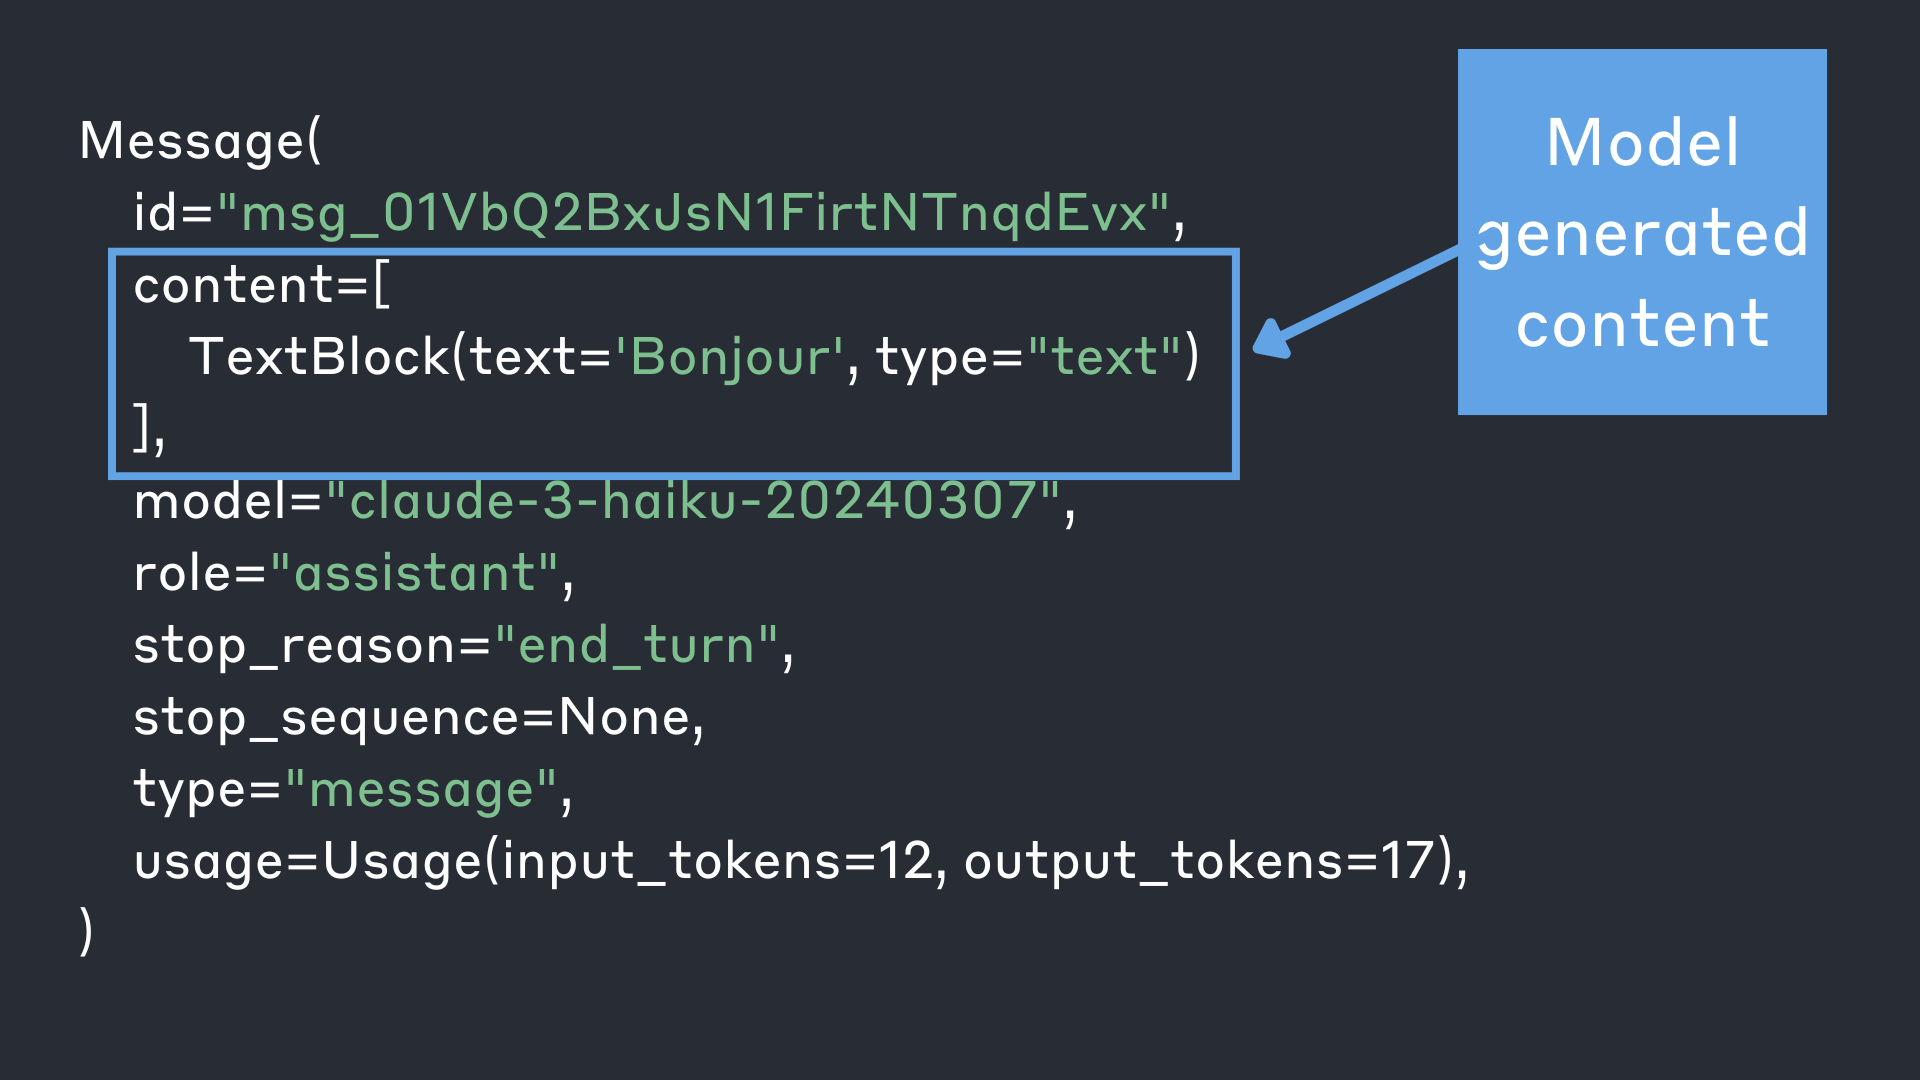

 In order to access the actual text content of the model's response, we need to do the following:



In [9]:
print(response.content[0].text)

Bonjour.


In addition to `content`, the `Message` object contains some other pieces of information:

* `id` - a unique object identifier
* `type` - The object type, which will always be "message"
* `role` - The conversational role of the generated message. This will always be "assistant".
* `model` - The model that handled the request and generated the response
* `stop_reason` - The reason the model stopped generating.  We'll learn more about this later.
* `stop_sequence` - We'll learn more about this shortly.
* `usage` - information on billing and rate-limit usage. Contains information on:
    * `input_tokens` - The number of input tokens that were used.
    * `output_tokens` - The number of output tokens that were used.

It's important to know that we have access to these pieces of information, but if you only remember one thing, make it this: `content` contains the actual model-generated content

***
## Exercise 

Write a function called translate that expects two arguments: 
* A word
* A language

When you call the `translate` function, it should return the result of asking Claude to translate `word` into `language`.  For example:

```py
translate("hello", "Spanish")
# 'The word "hello" translated into Spanish is: Hola'

translate("chicken", "Italian")
# 'The Italian word for "chicken" is: pollo'
```

Bonus points if you can write a prompt so that Claude only responds with the translated word and no preamble, like this: 

```py
translate("chicken", "Italian")
# 'pollo'
```


<details>
  <summary>View exercise solution</summary>
  
  Here's one possible solution:
  
  ```py
  def translate(word, language):
    response = client.messages.create(
        model="claude-3-opus-20240229",
        max_tokens=1000,
        messages=[
            {"role": "user", "content": f"Translate the word {word} into {language}.  Only respond with the translated word, nothing else"}
        ]
    )
    return response.content[0].text 
  ```

</details>




***

## Message list mistakes

### Mistake #1: starting with an assistant message

When you're starting out, it's easy to make mistakes when working with the `messages` list.  The list of messages must start with a `user` message.  The following code generates an error because the messages list starts with an assistant message:

In [10]:
response = client.messages.create(
    model="claude-3-haiku-20240307",
    max_tokens=1000,
    messages=[
        {"role": "assistant", "content": "Hello there!"}
    ]
)
print(response.content[0].text)

BadRequestError: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages: first message must use the "user" role'}}

### Mistake #2: improperly alternating messages

Messages must alternate between `user` and `assistant`, and we'll get an error if we don't follow this rule:

In [12]:
response = client.messages.create(
    model="claude-3-haiku-20240307",
    max_tokens=1000,
    messages=[
        {"role": "user", "content": "Hey there!"},
        {"role": "assistant", "content": "Hi there!"},
        {"role": "assistant", "content": "How can I help you??"}
    ]
)
print(response.content[0].text)

BadRequestError: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages: roles must alternate between "user" and "assistant", but found multiple "assistant" roles in a row'}}

## Messages list use cases



### Putting words in Claude's mouth

Another common strategy for getting very specific outputs is to "put words in Claude's mouth".  Instead of only providing `user` messages to Claude, we can also supply an `assistant` message that Claude will use when generating output.  

When using Anthropic’s API, you are not limited to just the `user` message. If you supply an `assistant` message, Claude will continue the conversation from the last `assistant` token.  Just remember that we must start with a `user` message.

Suppose I want Claude to write me a haiku that starts with the first line, "calming mountain air".  I can provide the following conversation history: 

```py
messages=[
        {"role": "user", "content": f"Generate a beautiful haiku"},
        {"role": "assistant", "content": "calming mountain air"}
    ]
```
We tell Claude that we want it to generate a Haiku AND we put the first line of the Haiku in Claude's mouth




In [10]:
response = client.messages.create(
    model="claude-3-haiku-20240307",
    max_tokens=500,
    messages=[
        {"role": "user", "content": f"Generate a beautiful haiku"},
        {"role": "assistant", "content": "calming mountain air"}
    ]
)
print(response.content[0].text)

,
dancing sunlight on still waters,
nature's gentle grace.


To get the entire haiku, starting with the line we provided:

In [11]:
print("calming mountain air" + response.content[0].text)

calming mountain air,
dancing sunlight on still waters,
nature's gentle grace.


### Few-shot prompting

One of the most useful prompting strategies is called "few-shot prompting" which involves providing a model with a small number of **examples**.  These examples help guide Claude's generated output.  The messages conversation history is an easy way to provide examples to Claude.

For example, suppose we want to use Claude to analyze the sentiment in tweets.  We could start by simply asking Claude to "please analyze the sentiment in this tweet: " and see what sort of output we get:

In [18]:
response = client.messages.create(
    model="claude-3-haiku-20240307",
    max_tokens=500,
    messages=[
        {"role": "user", "content": f"Analyze the sentiment in this tweet: Just tried the new spicy pickles from @PickleCo, and my taste buds are doing a happy dance! 🌶️🥒 #pickleslove #spicyfood"},
    ]
)
print(response.content[0].text)

The sentiment in this tweet is overwhelmingly positive. The user expresses their enjoyment of the new spicy pickles from @PickleCo, using enthusiastic language and emojis to convey their delight.

Positive indicators:
1. "My taste buds are doing a happy dance!" - This phrase indicates that the user is extremely pleased with the taste of the pickles, to the point of eliciting a joyful physical response.

2. Emojis - The use of the hot pepper 🌶️ and cucumber 🥒 emojis further emphasizes the user's excitement about the spicy pickles.

3. Hashtags - The inclusion of #pickleslove and #spicyfood hashtags suggests that the user has a strong affinity for pickles and spicy food, and the new product aligns perfectly with their preferences.

4. Exclamation mark - The exclamation mark at the end of the first sentence adds emphasis to the user's positive experience.

Overall, the tweet conveys a strong sense of satisfaction, excitement, and enjoyment related to trying the new spicy pickles from @Pic

The first time I ran the above code, Claude generated this long response: 
```
The sentiment in this tweet is overwhelmingly positive. The user expresses their enjoyment of the new spicy pickles from @PickleCo, using enthusiastic language and emojis to convey their delight.

Positive indicators:
1. "My taste buds are doing a happy dance!" - This phrase indicates that the user is extremely pleased with the taste of the pickles, to the point of eliciting a joyful physical response.

2. Emojis - The use of the hot pepper 🌶️ and cucumber 🥒 emojis further emphasizes the user's excitement about the spicy pickles.

3. Hashtags - The inclusion of #pickleslove and #spicyfood hashtags suggests that the user has a strong affinity for pickles and spicy food, and the new product aligns perfectly with their preferences.

4. Exclamation mark - The exclamation mark at the end of the first sentence adds emphasis to the user's positive experience.

Overall, the tweet conveys a strong sense of satisfaction, excitement, and enjoyment related to trying the new spicy pickles from @PickleCo.
```

This is a great response, but it's probably way more information than we need from Claude, especially if we're trying to automate the sentiment analysis of a large number of tweets.  

We might prefer that Claude respond with a standardized output format like a single word (POSITIVE, NEUTRAL, NEGATIVE) or a numeric value (1, 0, -1).  For readability and simplicity, let's get Claude to respond with either "POSITIVE" or "NEGATIVE".  One way of doing this is through few-shot prompting.  We can provide Claude with a conversation history that shows exactly how we want it to respond: 

```py
messages=[
        {"role": "user", "content": "Unpopular opinion: Pickles are disgusting. Don't @ me"},
        {"role": "assistant", "content": "NEGATIVE"},
        {"role": "user", "content": "I think my love for pickles might be getting out of hand. I just bought a pickle-shaped pool float"},
        {"role": "assistant", "content": "POSITIVE"},
        {"role": "user", "content": "Seriously why would anyone ever eat a pickle?  Those things are nasty!"},
        {"role": "assistant", "content": "NEGATIVE"},
        {"role": "user", "content": "Just tried the new spicy pickles from @PickleCo, and my taste buds are doing a happy dance! 🌶️🥒 #pickleslove #spicyfood"},
    ]
```



In [21]:
response = client.messages.create(
    model="claude-3-haiku-20240307",
    max_tokens=500,
    messages=[
        {"role": "user", "content": "Unpopular opinion: Pickles are disgusting. Don't @ me"},
        {"role": "assistant", "content": "NEGATIVE"},
        {"role": "user", "content": "I think my love for pickles might be getting out of hand. I just bought a pickle-shaped pool float"},
        {"role": "assistant", "content": "POSITIVE"},
        {"role": "user", "content": "Seriously why would anyone ever eat a pickle?  Those things are nasty!"},
        {"role": "assistant", "content": "NEGATIVE"},
        {"role": "user", "content": "Just tried the new spicy pickles from @PickleCo, and my taste buds are doing a happy dance! 🌶️🥒 #pickleslove #spicyfood"},
    ]
)
print(response.content[0].text)

POSITIVE


***

## Exercise

### Your task: build a chatbot

Build a simple multi-turn command-line chatbot script. The messages format lends itself to building chat-based applications.  To build a chat-bot with Claude, it's as simple as:

1. Keep a list to store the conversation history
2. Ask a user for a message using `input()` and add the user input to the messages list
3. Send the message history to Claude
4. Print out Claude's response to the user
5. Add Claude's assistant response to the history
6. Go back to step 2 and repeat! (use a loop and provide a way for users to quit!)


<details>
    <summary>View exercise solution</summary>

    ```py

    conversation_history = []

    while True:
        user_input = input("User: ")
        
        if user_input.lower() == "quit":
            print("Conversation ended.")
            break
        
        conversation_history.append({"role": "user", "content": user_input})
    
        response = client.messages.create(
            model="claude-3-haiku-20240307",
            messages=conversation_history,
            max_tokens=500
        )
    
        assistant_response = response.content[0].text
        print(f"Assistant: {assistant_response}")
        conversation_history.append({"role": "assistant", "content": assistant_response})
    ```
</details>

***
